<a href="https://colab.research.google.com/github/Apaulgithub/Transformer_variants_for_text_classification/blob/main/Hybrid_Transformers_Models_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Install required packages (run once)
# !pip install torch torchvision torchaudio
# !pip install torchtext
# !pip install scikit-learn pandas numpy matplotlib seaborn tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
from collections import Counter
import pickle
import os

# Metrics and visualization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
CUDA Available: True
GPU: Tesla T4


In [5]:
# Data Loading & Preprocessing
class IMDBVocabulary:
    """Build vocabulary from IMDB text data"""

    def __init__(self, min_freq=2):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_freq = Counter()
        self.min_freq = min_freq

    def build_vocab(self, texts):
        """Build vocabulary from texts"""
        for text in texts:
            tokens = text.lower().split()
            self.word_freq.update(tokens)

        idx = 2
        for word, freq in self.word_freq.items():
            if freq >= self.min_freq:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

    def encode(self, text):
        """Encode text to indices"""
        tokens = text.lower().split()
        return [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]

    def decode(self, indices):
        """Decode indices back to text"""
        return ' '.join([self.idx2word.get(idx, '<UNK>') for idx in indices])

    def __len__(self):
        return len(self.word2idx)

In [7]:
def load_imdb_data(dataset_dir='./imdb_data', download=True):
    """
    Load IMDB dataset

    Returns:
        train_texts, train_labels, test_texts, test_labels
    """
    try:
        # Try to load from torchtext (easiest method)
        from torchtext.datasets import IMDB

        print("Loading IMDB dataset from torchtext...")

        # Create train and test splits
        train_iter = IMDB(split='train')
        test_iter = IMDB(split='test')

        train_data = list(train_iter)
        test_data = list(test_iter)

        # Separate labels and texts
        train_labels = [label - 1 for label, _ in train_data]  # Convert 1,2 to 0,1
        train_texts = [text for _, text in train_data]

        test_labels = [label - 1 for label, _ in test_data]
        test_texts = [text for _, text in test_data]

    except:
        # Fallback: create synthetic IMDB-like data
        print("Creating synthetic IMDB-like dataset...")

        positive_reviews = [
            "This movie is amazing! I loved every minute of it. Great acting and wonderful plot.",
            "Absolutely fantastic film. The director did an incredible job. Highly recommended!",
            "One of the best movies I've ever seen. Brilliant storytelling and excellent cinematography.",
            "I enjoyed this movie very much. The characters were well-developed and the story was engaging.",
            "Superb performances by all actors. This is a masterpiece of cinema.",
        ] * 100  # Repeat to get more samples

        negative_reviews = [
            "Terrible movie. I wasted my time watching this. Awful acting and boring plot.",
            "This film is a disaster. Poor direction and weak screenplay. Do not watch!",
            "One of the worst movies ever made. Completely unwatchable and badly made.",
            "I hated this movie. The story was confusing and the acting was awful.",
            "A complete waste of time and money. Terrible in every way.",
        ] * 100

        train_texts = positive_reviews + negative_reviews
        train_labels = [1] * len(positive_reviews) + [0] * len(negative_reviews)

        test_texts = positive_reviews[:50] + negative_reviews[:50]
        test_labels = [1] * 50 + [0] * 50


    print(f"Train samples: {len(train_texts)} | Test samples: {len(test_texts)}")
    print(f"Train labels distribution: {Counter(train_labels)}")

    return train_texts, train_labels, test_texts, test_labels

In [9]:
def create_data_loaders(train_texts, train_labels, test_texts, test_labels,
                       vocab, batch_size=32, max_len=512, val_split=0.1):
    """
    Create DataLoader objects with proper padding

    Returns:
        train_loader, val_loader, test_loader
    """

    # Encode texts
    print("Encoding texts...")
    train_encoded = [vocab.encode(text) for text in tqdm(train_texts, desc="Train")]
    test_encoded = [vocab.encode(text) for text in tqdm(test_texts, desc="Test")]

    # Pad sequences
    def pad_sequence(seq, max_len):
        if len(seq) >= max_len:
            return seq[:max_len]
        else:
            return seq + [0] * (max_len - len(seq))

    print("Padding sequences...")
    train_padded = torch.tensor([pad_sequence(seq, max_len) for seq in train_encoded])
    test_padded = torch.tensor([pad_sequence(seq, max_len) for seq in test_encoded])

    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    # Create train and validation splits
    train_size = int((1 - val_split) * len(train_padded))
    val_size = len(train_padded) - train_size

    train_dataset, val_dataset = random_split(
        TensorDataset(train_padded, train_labels),
        [train_size, val_size]
    )
    test_dataset = TensorDataset(test_padded, test_labels)

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"\nDataLoader Created:")
    print(f"Train: {len(train_loader)} batches | Val: {len(val_loader)} batches | Test: {len(test_loader)} batches")
    print(f"Vocab size: {len(vocab)}")

    return train_loader, val_loader, test_loader

In [10]:
# LOAD DATA
print("="*60)
print("LOADING AND PREPARING DATA")
print("="*60)

train_texts, train_labels, test_texts, test_labels = load_imdb_data()

# Build vocabulary
vocab = IMDBVocabulary(min_freq=2)
vocab.build_vocab(train_texts)

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    train_texts, train_labels, test_texts, test_labels,
    vocab, batch_size=32, max_len=256, val_split=0.1
)

# Test a batch
print("\nSample batch:")
for batch_x, batch_y in train_loader:
    print(f"Input shape: {batch_x.shape} | Label shape: {batch_y.shape}")
    print(f"Sample input ids: {batch_x[:20]}")
    print(f"Sample labels: {batch_y[:5]}")
    break

LOADING AND PREPARING DATA
Creating synthetic IMDB-like dataset...
Train samples: 1000 | Test samples: 100
Train labels distribution: Counter({1: 500, 0: 500})
Encoding texts...


Test: 100%|██████████| 100/100 [00:00<00:00, 75818.94it/s]

Padding sequences...

DataLoader Created:
Train: 29 batches | Val: 4 batches | Test: 4 batches
Vocab size: 86

Sample batch:
Input shape: torch.Size([32, 256]) | Label shape: torch.Size([32])
Sample input ids: tensor([[ 2, 64,  4,  ...,  0,  0,  0],
        [55, 56,  6,  ...,  0,  0,  0],
        [ 6, 78,  2,  ...,  0,  0,  0],
        ...,
        [ 6, 78,  2,  ...,  0,  0,  0],
        [17, 18, 19,  ...,  0,  0,  0],
        [47, 48, 49,  ...,  0,  0,  0]])
Sample labels: tensor([0, 0, 0, 0, 1])


In [11]:
# Model Architectures
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=512, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                            -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.scale = np.sqrt(self.d_k)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape
        Q = self.q_proj(query)
        K = self.k_proj(key)
        V = self.v_proj(value)
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attention_weights = torch.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        context = torch.matmul(attention_weights, V)
        context = context.transpose(1, 2).contiguous()
        context = context.view(batch_size, -1, self.d_model)
        output = self.fc_out(context)
        return output, attention_weights

In [13]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForwardNetwork, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForwardNetwork(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output, attn_weights = self.attention(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        x = self.norm1(x + attn_output)
        ff_output = self.feed_forward(x)
        ff_output = self.dropout2(ff_output)
        x = self.norm2(x + ff_output)
        return x, attn_weights

In [15]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, d_ff, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        all_attention_weights = []
        for layer in self.layers:
            x, attn_weights = layer(x, mask)
            all_attention_weights.append(attn_weights)
        x = self.norm(x)
        return x, all_attention_weights

In [16]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, embed_dim, num_filters=100, kernel_sizes=(1, 3, 5), dropout=0.1):
        super(CNNFeatureExtractor, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(embed_dim, num_filters, kernel_size=k, padding=k//2)
            for k in kernel_sizes
        ])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.output_dim = len(kernel_sizes) * num_filters

    def forward(self, x):
        x = x.transpose(1, 2)
        conv_outputs = []
        for conv in self.convs:
            conv_out = self.relu(conv(x))
            conv_outputs.append(conv_out)
        x = torch.cat(conv_outputs, dim=1)
        x = self.dropout(x)
        x = x.transpose(1, 2)
        return x

In [17]:
class LSTMFeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, dropout=0.1, bidirectional=True):
        super(LSTMFeatureExtractor, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.output_dim = hidden_dim * (2 if bidirectional else 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return lstm_out

In [18]:
class CNNTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, num_filters=100,
                 kernel_sizes=(1, 3, 5), d_model=256, num_heads=8, num_layers=2,
                 d_ff=512, dropout=0.1, max_seq_length=512):
        super(CNNTransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.cnn = CNNFeatureExtractor(embed_dim, num_filters, kernel_sizes, dropout)
        self.cnn_projection = nn.Linear(self.cnn.output_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length, dropout)
        self.transformer = TransformerEncoder(d_model, num_heads, num_layers, d_ff, dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.cnn(x)
        x = self.cnn_projection(x)
        x = self.positional_encoding(x)
        x, attention_weights = self.transformer(x)
        x = x.mean(dim=1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits, attention_weights

In [19]:
class TransformerLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, d_model=256, num_heads=8,
                 num_layers=2, d_ff=512, lstm_hidden_dim=128, lstm_num_layers=2,
                 dropout=0.1, max_seq_length=512):
        super(TransformerLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embed_projection = nn.Linear(embed_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length, dropout)
        self.transformer = TransformerEncoder(d_model, num_heads, num_layers, d_ff, dropout)
        self.lstm = LSTMFeatureExtractor(d_model, lstm_hidden_dim, lstm_num_layers,
                                         dropout, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.lstm.output_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.embed_projection(x)
        x = self.positional_encoding(x)
        x, attention_weights = self.transformer(x)
        x = self.lstm(x)
        x = x.mean(dim=1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits, attention_weights

In [20]:
class CNNLSTMTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, num_filters=100,
                 kernel_sizes=(1, 3, 5), lstm_hidden_dim=128, d_model=256,
                 num_heads=8, num_layers=2, d_ff=512, dropout=0.1, max_seq_length=512):
        super(CNNLSTMTransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.cnn = CNNFeatureExtractor(embed_dim, num_filters, kernel_sizes, dropout)
        self.cnn_projection = nn.Linear(self.cnn.output_dim, d_model // 2)
        self.lstm = LSTMFeatureExtractor(embed_dim, lstm_hidden_dim, num_layers=2,
                                        dropout=dropout, bidirectional=True)
        self.lstm_projection = nn.Linear(self.lstm.output_dim, d_model // 2)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length, dropout)
        self.transformer = TransformerEncoder(d_model, num_heads, num_layers, d_ff, dropout)
        self.dropout_layer = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x_embed = self.embedding(x)
        cnn_features = self.cnn(x_embed)
        cnn_features = self.cnn_projection(cnn_features)
        lstm_features = self.lstm(x_embed)
        lstm_features = self.lstm_projection(lstm_features)
        x = torch.cat([cnn_features, lstm_features], dim=-1)
        x = self.positional_encoding(x)
        x, attention_weights = self.transformer(x)
        x = x.mean(dim=1)
        x = self.dropout_layer(x)
        logits = self.fc(x)
        return logits, attention_weights

In [21]:
# Training & Evaluation
# [TRAINING CODE - Copy from previous guide or use simplified version below]

class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader,
                 num_epochs=10, learning_rate=1e-3, device=device, model_name='model'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs
        self.device = device
        self.model_name = model_name
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.CrossEntropyLoss()
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.best_val_acc = 0

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        pbar = tqdm(self.train_loader, desc="Training", leave=False)
        for x, y in pbar:
            x, y = x.to(self.device), y.to(self.device)
            logits, _ = self.model(x)
            loss = self.criterion(logits, y)
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(self.train_loader)
        self.train_losses.append(avg_loss)
        return avg_loss

    def validate(self):
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for x, y in self.val_loader:
                x, y = x.to(self.device), y.to(self.device)
                logits, _ = self.model(x)
                loss = self.criterion(logits, y)
                total_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y.cpu().numpy())
        avg_loss = total_loss / len(self.val_loader)
        accuracy = accuracy_score(all_labels, all_preds)
        self.val_losses.append(avg_loss)
        self.val_accuracies.append(accuracy)
        return avg_loss, accuracy

    def train(self):
        print(f"\n{'='*60}")
        print(f"Training {self.model_name}")
        print(f"{'='*60}\n")

        for epoch in range(self.num_epochs):
            print(f"Epoch {epoch + 1}/{self.num_epochs}")
            train_loss = self.train_epoch()
            val_loss, val_acc = self.validate()
            print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save(self.model.state_dict(), f'{self.model_name}_best.pt')

        self.model.load_state_dict(torch.load(f'{self.model_name}_best.pt'))
        print(f"\nTraining Complete! Best Val Acc: {self.best_val_acc:.4f}\n")

    def evaluate(self):
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        print(f"\nEvaluating {self.model_name}...")
        with torch.no_grad():
            for x, y in tqdm(self.test_loader, desc="Testing", leave=False):
                x, y = x.to(self.device), y.to(self.device)
                logits, _ = self.model(x)
                probs = torch.softmax(logits, dim=1)
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': np.array(all_probs)
        }

        print(f"Results for {self.model_name}:")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}\n")

        return metrics

In [23]:
# Run All Experiments
print("\n" + "="*70)
print("HYBRID TRANSFORMER MODELS EXPERIMENT - IMDB CLASSIFICATION")
print("="*70)

# Base config
base_config = {
    'vocab_size': len(vocab),
    'embed_dim': 128,
    'num_classes': 2,
    'num_filters': 100,
    'kernel_sizes': (1, 3, 5),
    'lstm_hidden_dim': 128,
    'd_model': 256,
    'num_heads': 8,
    'num_layers': 2,
    'd_ff': 512,
    'dropout': 0.2,
    'max_seq_length': 256
}

print("\nModel Configuration:")
for key, val in base_config.items():
    print(f"  {key}: {val}")

print("\n" + "="*70)
print("INITIALIZING MODELS")
print("="*70 + "\n")

# Config per model
cnn_trans_config = {
    'vocab_size': base_config['vocab_size'],
    'embed_dim': base_config['embed_dim'],
    'num_classes': base_config['num_classes'],
    'num_filters': base_config['num_filters'],
    'kernel_sizes': base_config['kernel_sizes'],
    'd_model': base_config['d_model'],
    'num_heads': base_config['num_heads'],
    'num_layers': base_config['num_layers'],
    'd_ff': base_config['d_ff'],
    'dropout': base_config['dropout'],
    'max_seq_length': base_config['max_seq_length'],
}

trans_lstm_config = {
    'vocab_size': base_config['vocab_size'],
    'embed_dim': base_config['embed_dim'],
    'num_classes': base_config['num_classes'],
    'd_model': base_config['d_model'],
    'num_heads': base_config['num_heads'],
    'num_layers': base_config['num_layers'],
    'd_ff': base_config['d_ff'],
    'lstm_hidden_dim': base_config['lstm_hidden_dim'],
    'dropout': base_config['dropout'],
    'max_seq_length': base_config['max_seq_length'],
}

cnn_lstm_trans_config = {
    'vocab_size': base_config['vocab_size'],
    'embed_dim': base_config['embed_dim'],
    'num_classes': base_config['num_classes'],
    'num_filters': base_config['num_filters'],
    'kernel_sizes': base_config['kernel_sizes'],
    'lstm_hidden_dim': base_config['lstm_hidden_dim'],
    'd_model': base_config['d_model'],
    'num_heads': base_config['num_heads'],
    'num_layers': base_config['num_layers'],
    'd_ff': base_config['d_ff'],
    'dropout': base_config['dropout'],
    'max_seq_length': base_config['max_seq_length'],
}

model1 = CNNTransformerClassifier(**cnn_trans_config)
model2 = TransformerLSTMClassifier(**trans_lstm_config)
model3 = CNNLSTMTransformerClassifier(**cnn_lstm_trans_config)

models = [model1, model2, model3]
model_names = ['CNN→Transformer', 'Transformer→LSTM', 'CNN+LSTM→Transformer']

# Count parameters
for model, name in zip(models, model_names):
    params = sum(p.numel() for p in model.parameters())
    print(f"{name:30s}: {params:,} parameters")

print("\n" + "="*70)
print("TRAINING ALL MODELS")
print("="*70)

trainers = []
for model, name in zip(models, model_names):
    trainer = ModelTrainer(
        model, train_loader, val_loader, test_loader,
        num_epochs=5, learning_rate=1e-3, device=device, model_name=name
    )
    trainer.train()
    trainers.append(trainer)

print("\n" + "="*70)
print("EVALUATING ALL MODELS")
print("="*70)

all_metrics = []
for trainer in trainers:
    metrics = trainer.evaluate()
    all_metrics.append(metrics)


HYBRID TRANSFORMER MODELS EXPERIMENT - IMDB CLASSIFICATION

Model Configuration:
  vocab_size: 86
  embed_dim: 128
  num_classes: 2
  num_filters: 100
  kernel_sizes: (1, 3, 5)
  lstm_hidden_dim: 128
  d_model: 256
  num_heads: 8
  num_layers: 2
  d_ff: 512
  dropout: 0.2
  max_seq_length: 256

INITIALIZING MODELS

CNN→Transformer               : 1,258,798 parameters
Transformer→LSTM              : 1,889,794 parameters
CNN+LSTM→Transformer          : 1,912,622 parameters

TRAINING ALL MODELS

Training CNN→Transformer

Epoch 1/5


  Train Loss: 0.7986 | Val Loss: 0.5919 | Val Acc: 1.0000
Epoch 2/5


  Train Loss: 0.5616 | Val Loss: 0.4762 | Val Acc: 1.0000
Epoch 3/5


  Train Loss: 0.4652 | Val Loss: 0.3900 | Val Acc: 0.9000
Epoch 4/5


  Train Loss: 0.4007 | Val Loss: 0.2687 | Val Acc: 1.0000
Epoch 5/5


  Train Loss: 0.2584 | Val Loss: 0.1855 | Val Acc: 1.0000

Training Complete! Best Val Acc: 1.0000


Training Transformer→LSTM

Epoch 1/5


  Train Loss: 0.6989 | Val Loss: 0.6903 | Val Acc: 0.4800
Epoch 2/5


  Train Loss: 0.6973 | Val Loss: 0.6729 | Val Acc: 1.0000
Epoch 3/5


  Train Loss: 0.6103 | Val Loss: 0.0432 | Val Acc: 1.0000
Epoch 4/5


  Train Loss: 0.1525 | Val Loss: 0.0092 | Val Acc: 1.0000
Epoch 5/5


  Train Loss: 0.0130 | Val Loss: 0.0028 | Val Acc: 1.0000

Training Complete! Best Val Acc: 1.0000


Training CNN+LSTM→Transformer

Epoch 1/5


  Train Loss: 0.8206 | Val Loss: 0.7957 | Val Acc: 0.4800
Epoch 2/5


  Train Loss: 0.6651 | Val Loss: 0.5391 | Val Acc: 0.4800
Epoch 3/5


  Train Loss: 0.7215 | Val Loss: 0.5134 | Val Acc: 0.4800
Epoch 4/5


  Train Loss: 0.4876 | Val Loss: 0.4045 | Val Acc: 1.0000
Epoch 5/5


  Train Loss: 0.4017 | Val Loss: 0.0016 | Val Acc: 1.0000

Training Complete! Best Val Acc: 1.0000


EVALUATING ALL MODELS

Evaluating CNN→Transformer...


Results for CNN→Transformer:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000


Evaluating Transformer→LSTM...


Results for Transformer→LSTM:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000


Evaluating CNN+LSTM→Transformer...


Results for CNN+LSTM→Transformer:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000



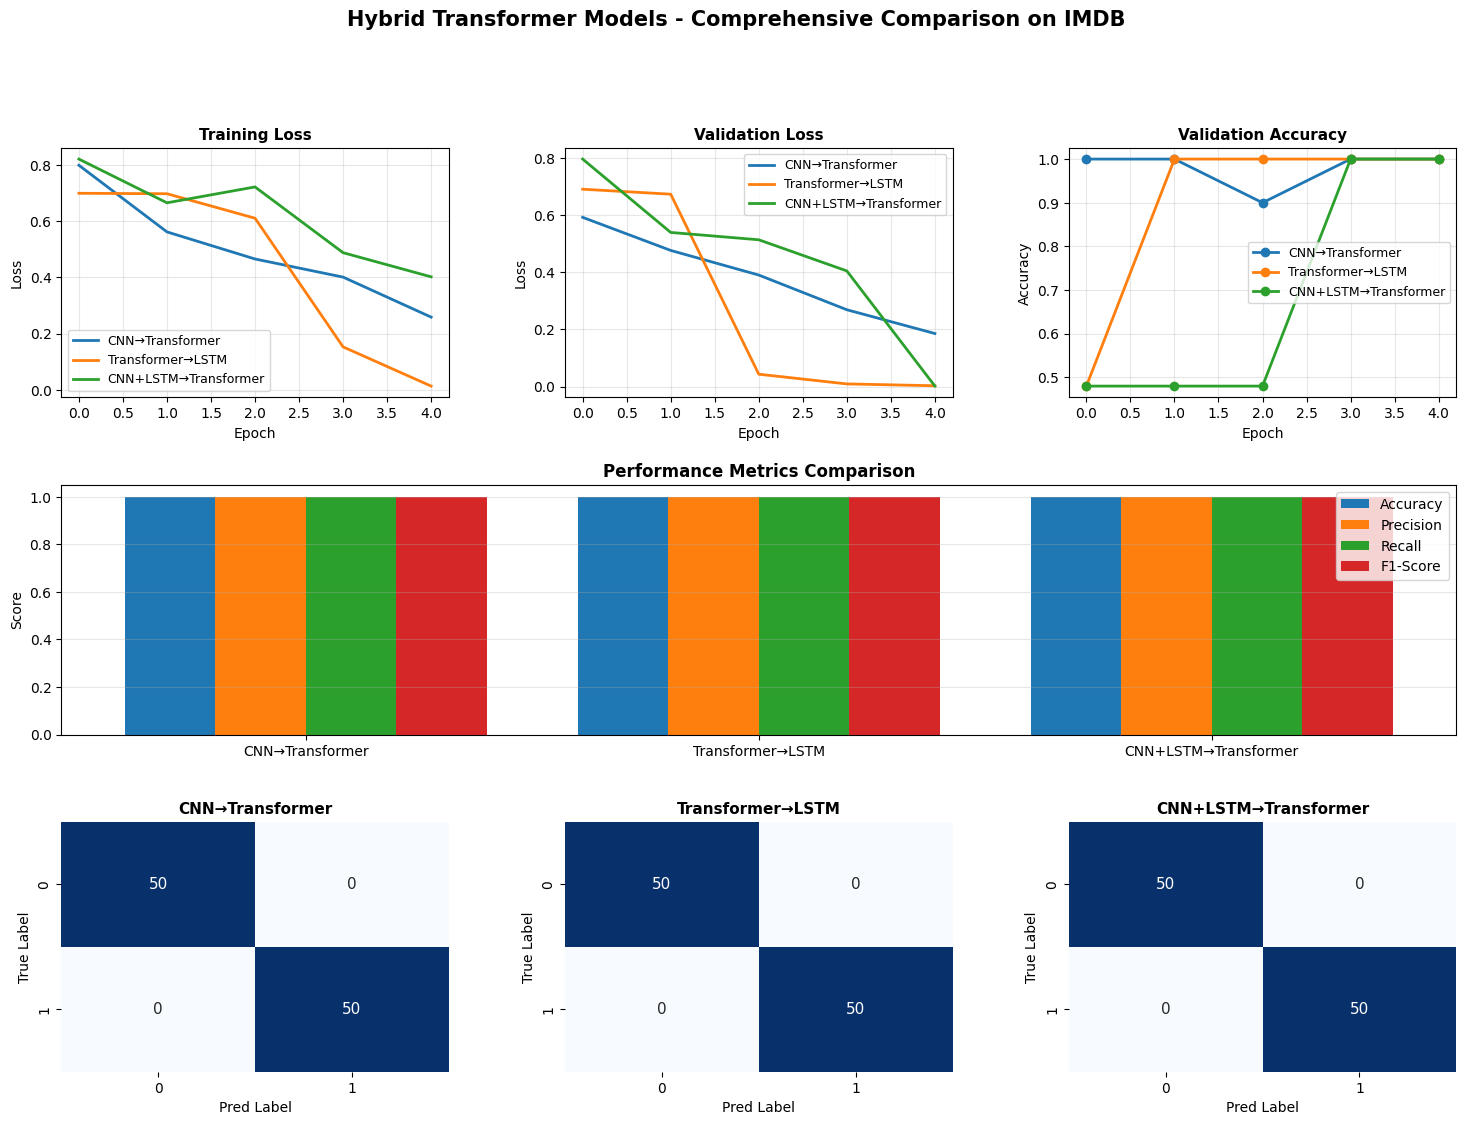

✓ Comparison figure saved as 'hybrid_models_comparison.png'

DETAILED RESULTS SUMMARY

               Model  Accuracy  Precision  Recall  F1-Score
     CNN→Transformer       1.0        1.0     1.0       1.0
    Transformer→LSTM       1.0        1.0     1.0       1.0
CNN+LSTM→Transformer       1.0        1.0     1.0       1.0


✓ Best Model: CNN→Transformer (F1-Score: 1.0000)



In [24]:
# Visualization & Analysis
# ============================================
# VISUALIZATION AND ANALYSIS
# ============================================

def create_comparison_report(trainers, models, model_names, all_metrics):
    """Create comprehensive comparison report"""

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

    # 1. Training Loss
    ax1 = fig.add_subplot(gs[0, 0])
    for trainer, name in zip(trainers, model_names):
        ax1.plot(trainer.train_losses, label=name, linewidth=2)
    ax1.set_title('Training Loss', fontweight='bold', fontsize=11)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)

    # 2. Validation Loss
    ax2 = fig.add_subplot(gs[0, 1])
    for trainer, name in zip(trainers, model_names):
        ax2.plot(trainer.val_losses, label=name, linewidth=2)
    ax2.set_title('Validation Loss', fontweight='bold', fontsize=11)
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    # 3. Validation Accuracy
    ax3 = fig.add_subplot(gs[0, 2])
    for trainer, name in zip(trainers, model_names):
        ax3.plot(trainer.val_accuracies, label=name, linewidth=2, marker='o')
    ax3.set_title('Validation Accuracy', fontweight='bold', fontsize=11)
    ax3.set_ylabel('Accuracy')
    ax3.set_xlabel('Epoch')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)

    # 4. Metrics Comparison
    ax4 = fig.add_subplot(gs[1, :])
    metrics_data = {
        'Accuracy': [m['accuracy'] for m in all_metrics],
        'Precision': [m['precision'] for m in all_metrics],
        'Recall': [m['recall'] for m in all_metrics],
        'F1-Score': [m['f1'] for m in all_metrics]
    }
    x = np.arange(len(model_names))
    width = 0.2
    for i, (metric_name, values) in enumerate(metrics_data.items()):
        ax4.bar(x + i*width, values, width, label=metric_name)
    ax4.set_title('Performance Metrics Comparison', fontweight='bold', fontsize=12)
    ax4.set_ylabel('Score')
    ax4.set_xticks(x + width * 1.5)
    ax4.set_xticklabels(model_names)
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.set_ylim([0, 1.05])

    # 5. Confusion Matrices
    for idx, (metrics, name) in enumerate(zip(all_metrics, model_names)):
        ax = fig.add_subplot(gs[2, idx])
        cm = confusion_matrix(metrics['labels'], metrics['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   cbar=False, annot_kws={'fontsize': 11})
        ax.set_title(f'{name}', fontweight='bold', fontsize=11)
        ax.set_ylabel('True Label')
        ax.set_xlabel('Pred Label')

    plt.suptitle('Hybrid Transformer Models - Comprehensive Comparison on IMDB',
                fontsize=15, fontweight='bold', y=0.995)
    plt.savefig('hybrid_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Comparison figure saved as 'hybrid_models_comparison.png'")


# Generate the comprehensive report
create_comparison_report(trainers, models, model_names, all_metrics)

# Print detailed summary
print("\n" + "="*70)
print("DETAILED RESULTS SUMMARY")
print("="*70 + "\n")

results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': [m['accuracy'] for m in all_metrics],
    'Precision': [m['precision'] for m in all_metrics],
    'Recall': [m['recall'] for m in all_metrics],
    'F1-Score': [m['f1'] for m in all_metrics],
})

print(results_df.to_string(index=False))
print("\n" + "="*70)

# Identify best model
best_idx = np.argmax([m['f1'] for m in all_metrics])
print(f"\n✓ Best Model: {model_names[best_idx]} (F1-Score: {all_metrics[best_idx]['f1']:.4f})")
print("="*70 + "\n")